# Tides evaluation
## First check: Maximum amplitude map compared against TPXO 7.2 solution
What I try do achive is a comparison of maximum tidal amplitude from ROMS against the TPXO7.2 solution (provides forcing for ROMS). To do so, I compare ROMS maximum sea surface height anomaly from a hourly record of 14 days against the summation of the amplitudes over all (8) constituents from the forcing file. 

In [7]:
# load roms history output as Xarray dataset
import xarray as xr
import matplotlib.pyplot as plt
import os
import numpy as np

file_path = os.path.join(os.pardir,'data','raw','waom10_full_forcing','ocean_his_hourly.nc')
ds = xr.open_dataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
roms_ampl_max = ds.zeta.max('ocean_time')-ds.zeta.mean('ocean_time')

In [22]:
# load tpxo forcing amplitude and phase information as Xarray dataset
tpxo_path = os.path.join(os.pardir,'data','raw','waom10_full_forcing','Data','waom10','waom10_tds_large.nc')
dsf = xr.open_dataset(tpxo_path)

# calculate the superposition of amplitudes of all constituents (max tidal amplitude possible)
tpxo_ampl_max = dsf.sum('tide_period')

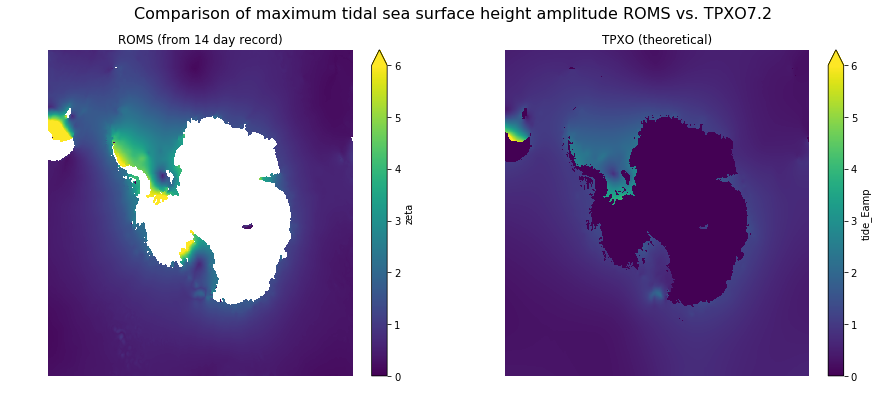

In [23]:
# plot both next to each other with same colorbounds
plt.clf()
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(15,6))
fig.suptitle('Comparison of maximum tidal sea surface height amplitude ROMS vs. TPXO7.2',fontsize=16)
roms_ampl_max.plot(ax=ax1,vmax=6)
ax1.set_title('ROMS (from 14 day record)')
ax1.axis('off')
tpxo_ampl_max.tide_Eamp.plot(ax=ax2,vmax=6)
ax2.set_title('TPXO (theoretical)')
ax2.axis('off')
plt.show()

... Roms gets about two times to high under the big ice shelves. Since the height looks ok everywhere else, this might be related to the kelvin waves. Two ideas to fix this:
1. no forcing on the continental shelf
2. increase bottom/ice shelf drag, high resolution might help

## Better: Comparison of M2 and O1 amplitude maps
(others violate Rayleigh condition with just 14 day record) 

In [14]:
import ttide as tt
import numpy as np
import pandas as pd

(365,) 1996-12-31 01:00:00 -52.25844367420482


Apply t_tide tidal harmonic analysis on every grid point and fill O1 and M2 amplitude maps in Xarray dataset

In [ ]:
ds['O1_ampl']=(('eta_rho','xi_rho'),np.zeros((ds.eta_rho.size,ds.xi_rho.size)))
ds['M2_ampl']=(('eta_rho','xi_rho'),np.zeros((ds.eta_rho.size,ds.xi_rho.size)))

#stime = datetime(1996,12,31,1)
stime = pd.to_datetime(ds.ocean_time[0].values)

for xi in ds.xi_rho.values:
    print('processing xi: ',xi)
    for eta in ds.eta_rho.values:
        
        ds_sl = ds.isel(eta_rho=eta,xi_rho=xi)
        
        if ds_sl.zeta.isnull().values.any():
            ds.O1_ampl[eta,xi] = np.NaN
            ds.M2_ampl[eta,xi] = np.NaN
        else:
            signal = ds_sl.zeta.values
            latitude = ds_sl.lat_rho.values
            try:
                ttide_out = tt.t_tide(signal,stime=stime,lat=latitude,out_style=None)

                ind_O1 = list(ttide_out['nameu']).index(b'O1  ')
                ind_M2 = list(ttide_out['nameu']).index(b'M2  ')
        
                O1_ampl = ttide_out['tidecon'][ind_O1][1]
                M2_ampl = ttide_out['tidecon'][ind_M2][1]
            
                ds.O1_ampl[eta,xi] = O1_ampl
                ds.M2_ampl[eta,xi] = M2_ampl
                
            except TypeError:
                
                ds.O1_ampl[eta,xi] = np.NaN
                ds.M2_ampl[eta,xi] = np.NaN

processing xi:  0
processing xi:  1
processing xi:  2
processing xi:  3
processing xi:  4
processing xi:  5
processing xi:  6
processing xi:  7
processing xi:  8
processing xi:  9
processing xi:  10
processing xi:  11
processing xi:  12


/home/ubuntu/bigStick/anaconda3/lib/python3.6/site-packages/ttide-0.3_exp-py3.6.egg/ttide/t_tide.py:620: RuntimeWarning: invalid value encountered in true_divide
  snr = (tidecon[:, 0] / tidecon[:, 1]) ** 2
/home/ubuntu/bigStick/anaconda3/lib/python3.6/site-packages/ttide-0.3_exp-py3.6.egg/ttide/t_predic.py:57: RuntimeWarning: invalid value encountered in true_divide
  snr = (tidecon[:, 0] / tidecon[:, 1]) ** 2
/home/ubuntu/bigStick/anaconda3/lib/python3.6/site-packages/ttide-0.3_exp-py3.6.egg/ttide/t_predic.py:60: RuntimeWarning: invalid value encountered in greater
  I = snr > synth


No predictions with this SNR
processing xi:  13
processing xi:  14
processing xi:  15
processing xi:  16
processing xi:  17
processing xi:  18
processing xi:  19
processing xi:  20
processing xi:  21
processing xi:  22
processing xi:  23
processing xi:  24
processing xi:  25
processing xi:  26
processing xi:  27
processing xi:  28
processing xi:  29
processing xi:  30
processing xi:  31
processing xi:  32
processing xi:  33
processing xi:  34
processing xi:  35
processing xi:  36
processing xi:  37
processing xi:  38
processing xi:  39
processing xi:  40
processing xi:  41
processing xi:  42
processing xi:  43
processing xi:  44
processing xi:  45
processing xi:  46
processing xi:  47
processing xi:  48
processing xi:  49
processing xi:  50
processing xi:  51
processing xi:  52
processing xi:  53
processing xi:  54
processing xi:  55
processing xi:  56
processing xi:  57
processing xi:  58
processing xi:  59
processing xi:  60
processing xi:  61
processing xi:  62
processing xi:  63
pr

Plot against TPXO O1 and M2 amplitude maps

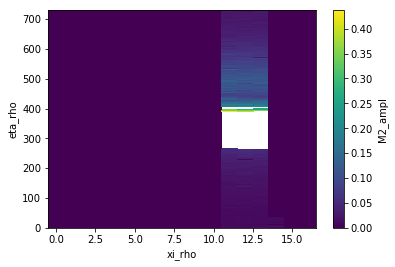

In [44]:
ds.M2_ampl[:,289:306].plot()
plt.show()

## No forcing on continental shelf

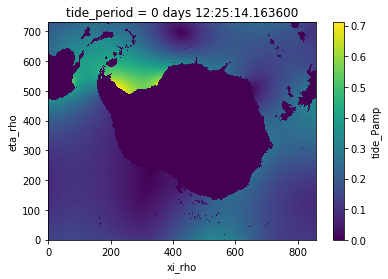

In [89]:
#mask tidal forcing
pott_path = os.path.join(os.pardir,'data','raw','waom10_full_forcing','Data','waom10','waom10_ptds_large.nc')
pott_ds = xr.open_dataset(pott_path)
Pamp_masked = pott_ds.tide_Pamp.where(ds.h.values + ds.zice.values >= 2000.0,0.0)
plt.clf()
Pamp_masked[0].plot()
plt.show()plt.clf()
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(15,6))
fig.suptitle('Comparison of maximum tidal sea surface height amplitude ROMS vs. TPXO7.2',fontsize=16)
roms_ampl_max.plot(ax=ax1,vmax=6)
ax1.set_title('ROMS (from 14 day record)')
ax1.axis('off')
tpxo_ampl_max.tide_Eamp.plot(ax=ax2,vmax=6)
ax2.set_title('TPXO (theoretical)')
ax2.axis('off')
plt.show()

In [91]:
out_path = os.path.join(pott_path,os.pardir,'waom10_ptds_masked.nc')
pott_ds['tide_Pamp']=Pamp_masked
pott_ds.to_netcdf(out_path,'w')

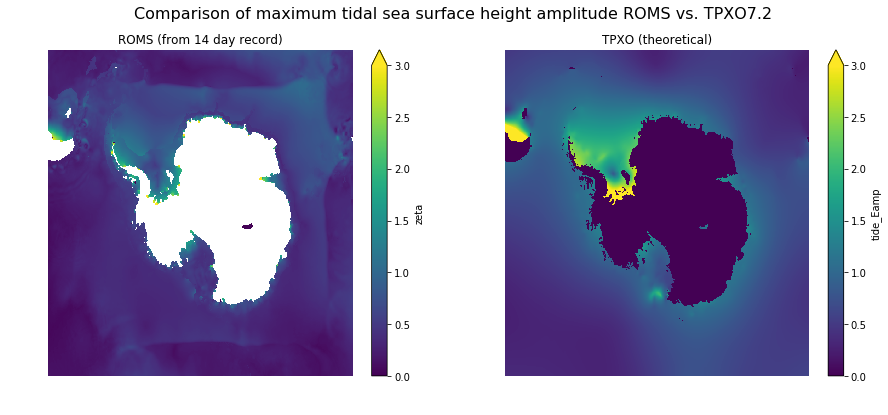

In [20]:
#look at results
file_path = os.path.join(os.pardir,'data','raw','waom10_tidal_mask','ocean_his_0001.nc')
ds_tm = xr.open_dataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
roms_ampl_max = ds_tm.zeta[0:48].max('ocean_time')-ds_tm.zeta[0:48].mean('ocean_time')

# plot against tpxo as before
plt.clf()
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(15,6))
fig.suptitle('Comparison of maximum tidal sea surface height amplitude ROMS vs. TPXO7.2',fontsize=16)
roms_ampl_max.plot(ax=ax1,vmax=3)
ax1.set_title('ROMS (from 14 day record)')
ax1.axis('off')
tpxo_ampl_max.tide_Eamp.plot(ax=ax2,vmax=3)
ax2.set_title('TPXO (theoretical)')
ax2.axis('off')
plt.show()

...seems to work, but we get this nasty gradients in SSH where the mask starts.